In [73]:
import sys
import os

# Add the project's root directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Also add the scripts directory to the path
scripts_path = os.path.join(project_root, 'scripts')
if scripts_path not in sys.path:
    sys.path.insert(0, scripts_path)

print(f"✅ Project root added to path: {project_root}")
print(f"✅ Scripts directory added to path: {scripts_path}")

✅ Project root added to path: d:\spectral_denoise
✅ Scripts directory added to path: d:\spectral_denoise\scripts


✅ Using device: cuda
✅ Model retrained and loaded from d:\spectral_denoise\models/resunet1d.pth
✅ Selecting random sample index: 249


C:\Users\nabhy\AppData\Local\Temp\ipykernel_10232\801018522.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

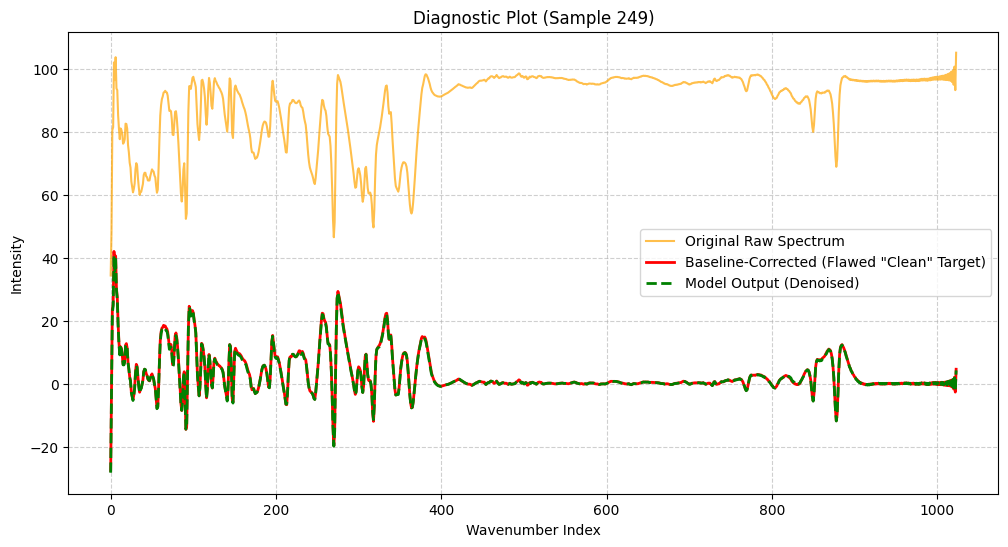

In [74]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from scipy.signal import resample

# Assuming the first cell with path correction has been run
from scripts.train_resunet import ResUNet1D

# --- 1. Settings ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
model_path = os.path.join(project_root, "models/resunet1d.pth")

# --- MODIFIED PATHS for diagnosis ---
raw_dir = os.path.join(project_root, "data/raw")
processed_dir = os.path.join(project_root, "data/processed")
TARGET_LEN = 1024

# --- 2. Load the RETRAINED Model ---
model = ResUNet1D().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model retrained and loaded from {model_path}")


# --- 3. Load a RANDOM Sample ---
raw_files = sorted([os.path.join(raw_dir, f) for f in os.listdir(raw_dir) if f.endswith(".txt")])
processed_files = sorted([os.path.join(processed_dir, f) for f in os.listdir(processed_dir) if f.endswith(".txt")])

random_index = random.randint(0, len(raw_files) - 1)
print(f"✅ Selecting random sample index: {random_index}")

# --- FIX: Add skiprows=1 to ignore the header row ---
raw_spectrum_np = np.loadtxt(raw_files[random_index], skiprows=1)[:, 1]
processed_spectrum_np = np.loadtxt(processed_files[random_index], skiprows=1)[:, 1]


# --- 4. Preprocess and Denoise the RAW Spectrum ---
raw_spectrum_resampled = resample(raw_spectrum_np, TARGET_LEN)
processed_spectrum_resampled = resample(processed_spectrum_np, TARGET_LEN)

noisy_tensor = torch.tensor(raw_spectrum_resampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    denoised_tensor = model(noisy_tensor)

denoised_spectrum_np = denoised_tensor.cpu().squeeze().numpy()


# --- 5. Visualize the Diagnosis ---
plt.figure(figsize=(12, 6))
plt.plot(raw_spectrum_resampled, label='Original Raw Spectrum', color='orange', alpha=0.7)
plt.plot(processed_spectrum_resampled, label='Baseline-Corrected (Flawed "Clean" Target)', color='red', linewidth=2)
plt.plot(denoised_spectrum_np, label='Model Output (Denoised)', color='green', linestyle='--', linewidth=2)
plt.title(f'Diagnostic Plot (Sample {random_index})')
plt.xlabel('Wavenumber Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()